<a href="https://colab.research.google.com/github/VishanOberoi/DeepLearning/blob/main/Dog_Breed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using a CNN to predict breeds of dogs.

Multiclass classification with 3 classes

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vishanoberoi","key":"3e187be6035cf526f4fec4e2f91767c1"}'}

In [2]:
#Installing the kaggle API
!pip install -q kaggle

In [3]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#Making the dir of dog dataset
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
#Searching kaggle for the dog dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           2467          6  0.1764706        


In [6]:
#Downloading this dataset

!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

100% 691M/691M [00:32<00:00, 23.9MB/s]
100% 691M/691M [00:32<00:00, 22.1MB/s]
/content


In [7]:
#Unizpping the data and removing all unusable files
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [8]:
# Imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [9]:
lables_all = pd.read_csv('/content/dog_dataset/labels.csv')
lables_all.shape


(10222, 2)

In [10]:
print(lables_all.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [11]:
#findin the number of each breed

all_breeds = lables_all["breed"]
all_breeds.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [12]:
# Selecting first 3 breeds (Limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = lables_all[(lables_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


In [13]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = tf.keras.utils.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0
    
# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:01<00:00, 299.32it/s]


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


In [14]:
#Creating the model

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 16)       0

In [15]:
#Splitting
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [16]:
# Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Epoch 1/100
2/2 [==============================] - 15s 2s/step - loss: 4.8910 - accuracy: 0.4141 - val_loss: 4.8699 - val_accuracy: 0.4000
Epoch 2/100
2/2 [==============================] - 1s 384ms/step - loss: 4.8620 - accuracy: 0.3867 - val_loss: 4.8503 - val_accuracy: 0.3538
Epoch 3/100
2/2 [==============================] - 1s 389ms/step - loss: 4.8351 - accuracy: 0.3828 - val_loss: 4.8309 - val_accuracy: 0.3538
Epoch 4/100
2/2 [==============================] - 1s 447ms/step - loss: 4.8099 - accuracy: 0.3789 - val_loss: 4.8102 - val_accuracy: 0.3538
Epoch 5/100
2/2 [==============================] - 1s 384ms/step - loss: 4.7823 - accuracy: 0.3750 - val_loss: 4.7889 - val_accuracy: 0.3538
Epoch 6/100
2/2 [==============================] - 1s 384ms/step - loss: 4.7552 - accuracy: 0.3867 - val_loss: 4.7652 - val_accuracy: 0.3538
Epoch 7/100
2/2 [==============================] - 1s 385ms/step - loss: 4.7276 - accuracy: 0.4141 - val_loss: 4.7407 - val_accuracy: 0.4000
Epoch 8/100
2/2

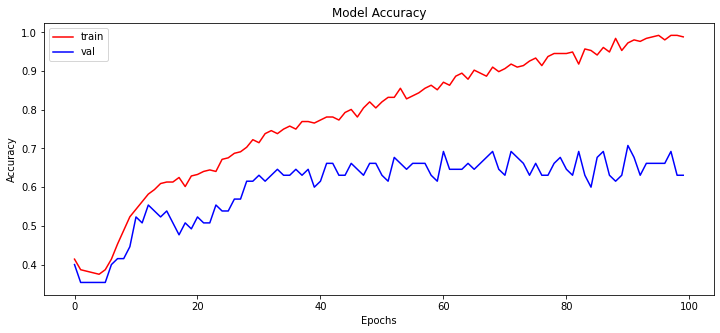

In [17]:
#Plotting
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [19]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy on test set \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 11ms/step - loss: 3.2864 - accuracy: 0.8333
Accuracy on test set 
  83.33 %


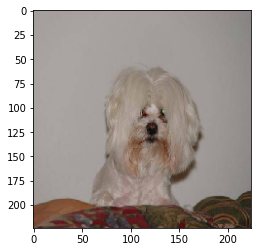

Originally :  maltese_dog
Predicted :  maltese_dog


In [24]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

In [25]:
#Tuning
#Creating the model

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
# model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
# model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 93312)             0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [26]:
# Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Epoch 1/100
2/2 [==============================] - 1s 572ms/step - loss: 5.0024 - accuracy: 0.3438 - val_loss: 4.9304 - val_accuracy: 0.3538
Epoch 2/100
2/2 [==============================] - 1s 397ms/step - loss: 4.7972 - accuracy: 0.4336 - val_loss: 4.6865 - val_accuracy: 0.5538
Epoch 3/100
2/2 [==============================] - 1s 396ms/step - loss: 4.6530 - accuracy: 0.4844 - val_loss: 4.5605 - val_accuracy: 0.4154
Epoch 4/100
2/2 [==============================] - 1s 396ms/step - loss: 4.5049 - accuracy: 0.5234 - val_loss: 4.4356 - val_accuracy: 0.4308
Epoch 5/100
2/2 [==============================] - 1s 395ms/step - loss: 4.3572 - accuracy: 0.5352 - val_loss: 4.2762 - val_accuracy: 0.4462
Epoch 6/100
2/2 [==============================] - 1s 396ms/step - loss: 4.2214 - accuracy: 0.6562 - val_loss: 4.1461 - val_accuracy: 0.4923
Epoch 7/100
2/2 [==============================] - 1s 399ms/step - loss: 4.0793 - accuracy: 0.6328 - val_loss: 4.0369 - val_accuracy: 0.4923
Epoch 8/100
2

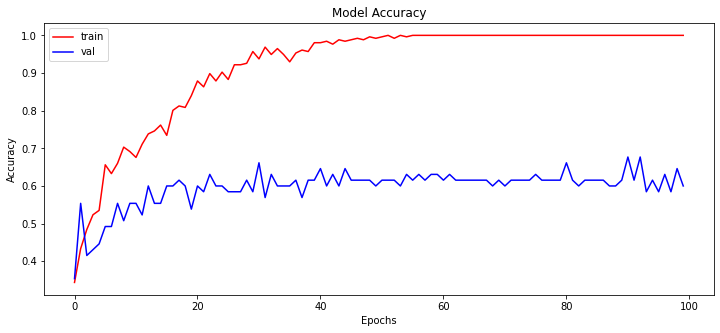

In [27]:
#Plotting
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [46]:
#Making the epochs 50
#Tuning
#Creating the model

model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
# model.add(MaxPool2D(pool_size=(2,2)))

# model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
# model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.001),metrics=['accuracy'])

# Training the model
epochs = 50
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (X_val, Y_val))

Epoch 1/50
2/2 [==============================] - 2s 633ms/step - loss: 5.6230 - accuracy: 0.3086 - val_loss: 6.1972 - val_accuracy: 0.3692
Epoch 2/50
2/2 [==============================] - 1s 396ms/step - loss: 4.8717 - accuracy: 0.4414 - val_loss: 3.4926 - val_accuracy: 0.3692
Epoch 3/50
2/2 [==============================] - 1s 394ms/step - loss: 3.4204 - accuracy: 0.2930 - val_loss: 3.2419 - val_accuracy: 0.3538
Epoch 4/50
2/2 [==============================] - 1s 405ms/step - loss: 3.2151 - accuracy: 0.3672 - val_loss: 3.1994 - val_accuracy: 0.2154
Epoch 5/50
2/2 [==============================] - 1s 393ms/step - loss: 3.1482 - accuracy: 0.5469 - val_loss: 3.1142 - val_accuracy: 0.4615
Epoch 6/50
2/2 [==============================] - 1s 396ms/step - loss: 3.0867 - accuracy: 0.5508 - val_loss: 3.0550 - val_accuracy: 0.3692
Epoch 7/50
2/2 [==============================] - 1s 388ms/step - loss: 2.9547 - accuracy: 0.5781 - val_loss: 3.0028 - val_accuracy: 0.4000
Epoch 8/50
2/2 [====

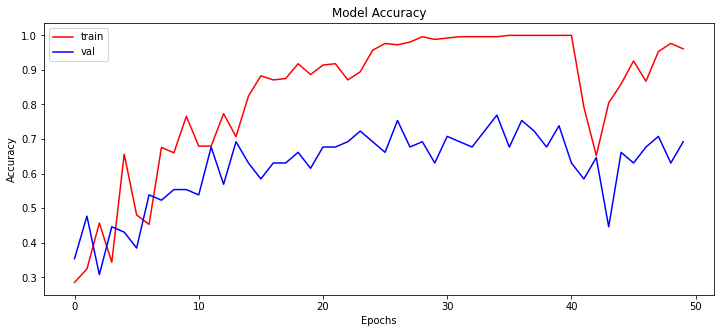

In [36]:
#Plotting
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

#Conclusion

Best training accuracy : 1.00

Best validating accuracy : 0.79

